# Importing Required Libraries

In [24]:
import sqlite3
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Data

In [2]:
conn = sqlite3.connect('european_database.sqlite')

query = """
SELECT 
    m.*, d.name, d.country
FROM matchs m 
JOIN divisions d ON d.division == m.Div
"""

df = (
    pd.read_sql_query(query, conn)
    .assign(Date = lambda x: pd.to_datetime(x.Date))
)

# Going through the dataset

In [23]:
df

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season,name,country
0,B1,2020-08-08,Club Brugge,Charleroi,0.0,1.0,A,2021,Division 1A,Belgium
1,B1,2020-08-08,Antwerp,Mouscron,1.0,1.0,D,2021,Division 1A,Belgium
2,B1,2020-08-08,Standard,Cercle Brugge,1.0,0.0,H,2021,Division 1A,Belgium
3,B1,2020-08-09,St Truiden,Gent,2.0,1.0,H,2021,Division 1A,Belgium
4,B1,2020-08-09,Waregem,Genk,1.0,2.0,A,2021,Division 1A,Belgium
...,...,...,...,...,...,...,...,...,...,...
120632,T1,2006-05-14,Galatasaray,Kayserispor,3.0,0.0,H,2006,Süper Lig,Turkey
120633,T1,2006-05-14,Gaziantepspor,Malatyaspor,1.0,0.0,H,2006,Süper Lig,Turkey
120634,T1,2006-05-14,Genclerbirligi,Rizespor,1.0,3.0,A,2006,Süper Lig,Turkey
120635,T1,2006-05-14,Samsunspor,Diyarbakirspor,1.0,0.0,H,2006,Süper Lig,Turkey


# Checking the datatypes of the columns

In [3]:
df.dtypes

Div                 object
Date        datetime64[ns]
HomeTeam            object
AwayTeam            object
FTHG               float64
FTAG               float64
FTR                 object
season               int64
name                object
country             object
dtype: object

# Taking a sample

In [4]:
df.sample(10)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season,name,country
4580,I1,2021-01-10,Udinese,Napoli,1.0,2.0,A,2021,Seria A,Italy
117719,I1,2006-03-05,Chievo,Lazio,2.0,2.0,D,2006,Seria A,Italy
35669,SC1,2017-03-18,Dunfermline,Ayr,0.0,1.0,A,2017,Scottish Championship,Scotland
83467,D2,2010-04-10,Cottbus,Fortuna Dusseldorf,4.0,2.0,H,2010,2. Bundesliga,Deutschland
115441,E3,2005-08-06,Stockport,Mansfield,2.0,2.0,D,2006,EFL League Two,England
77403,E2,2011-04-16,Sheffield Weds,Hartlepool,2.0,0.0,H,2011,EFL League One,England
1106,E0,2021-01-26,West Brom,Man City,0.0,5.0,A,2021,Premier League,England
44180,SP2,2016-02-20,Mallorca,Gimnastic,2.0,2.0,D,2016,LaLiga 2,Spain
50567,P1,2015-04-11,Benfica,Academica,5.0,1.0,H,2015,Liga NOS,Portugal
105907,D1,2007-02-24,Bochum,Aachen,2.0,2.0,D,2007,Bundesliga,Deutschland


# Checking the timeframe of the dataset

In [5]:
print(f"Min date: {df.Date.min()}")
print(f"Max date: {df.Date.max()}")

Min date: 2005-07-29 00:00:00
Max date: 2021-05-23 00:00:00


# Explore

# Creating functions to get club history

In [6]:
def get_club(club, home=True, season=None):
    if home:
        win, col = 'H', 'HomeTeam'
    else:
        win, col = 'A', 'AwayTeam'
    if season:
        df_club = df.copy().query('season == @season')
    else:
        df_club = df.copy()
    df_club = (
        df_club
        .query(f'{col} == @club')
        .assign(points=lambda x: x.FTR.apply(lambda s: 3 if s==win else (1 if s=='D' else 0)))
    )
    
    return df_club

def get_club_all(club, season=None):
    df_home = get_club(club, home=True, season=season)
    df_away = get_club(club, home=False, season=season)
    df_all = pd.concat([df_home, df_away])
    return df_all

def get_points_season(club, season):
    df_club_season = get_club_all(club, season=season)
    return df_club_season.points.sum()

# Checking the club history of (Paris SG)

In [7]:
psg = get_club_all('Paris SG')
psg.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season,name,country,points
3443,F1,2020-09-13,Paris SG,Marseille,0.0,1.0,A,2021,Ligue 1,France,0
3445,F1,2020-09-16,Paris SG,Metz,1.0,0.0,H,2021,Ligue 1,France,3
3467,F1,2020-10-02,Paris SG,Angers,6.0,1.0,H,2021,Ligue 1,France,3
3489,F1,2020-10-24,Paris SG,Dijon,4.0,0.0,H,2021,Ligue 1,France,3
3507,F1,2020-11-07,Paris SG,Rennes,3.0,0.0,H,2021,Ligue 1,France,3


# Showing the performance through a barchart

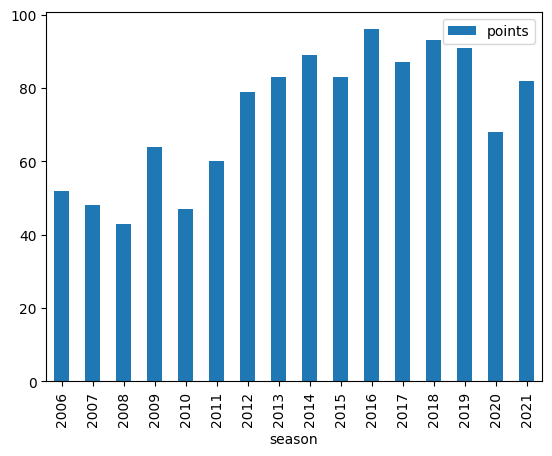

In [25]:
psg.groupby('season').agg({'points': 'sum'}).plot.bar()
plt.show()


# Creating functions to get final standings

In [9]:
def get_season_league(season, league):
    return df.query("season == @season and name == @league")

def get_final_classment(season, league):
    df_season_league = get_season_league(season, league)
    clubs_h, clubs_a = list(df_season_league.HomeTeam.unique()), list(df_season_league.AwayTeam.unique())
    clubs_h.sort()
    clubs_a.sort()
    
    assert clubs_h == clubs_a
    
    home_points = (
        df_season_league
        .groupby('HomeTeam').apply(lambda x: x.FTR.apply(lambda r: 3 if r=='H' else (1 if r=="D" else 0))).groupby('HomeTeam').sum()
    )
    home_points.name = "Home"

    away_points = (
        df_season_league
        .groupby('AwayTeam').apply(lambda x: x.FTR.apply(lambda r: 3 if r=='A' else (1 if r=="D" else 0))).groupby('AwayTeam').sum()
    )
    away_points.name = "Away"

    df_season_league_total_home_away = pd.concat([home_points, away_points], axis=1)

    df_season_league_total = (
        df_season_league_total_home_away
        .assign(Total = lambda x: x.sum(axis=1))
        .assign(rank=lambda x: x.Total.rank(ascending=False).astype('int'))
        .sort_values(by='rank')
    )
    
    return df_season_league_total

In [10]:
fr_l1_2021_classment = get_final_classment(2021, "Ligue 1")
fr_l1_2021_classment

,Home,Away,Total,rank
Lille,37,46,83,1
Paris SG,40,42,82,2
Monaco,41,37,78,3
Lyon,36,40,76,4
Marseille,35,25,60,5
Rennes,31,27,58,6
Lens,28,29,57,7
Montpellier,25,29,54,8
Nice,24,28,52,9
Metz,20,27,47,10



# Showing the final standings of clubs through barchart

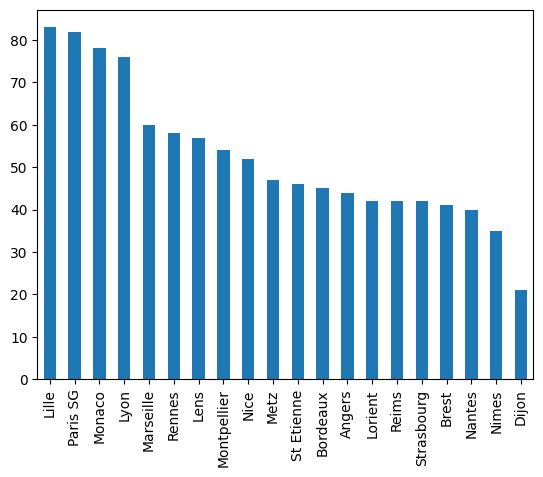

In [26]:
fr_l1_2021_classment.Total.plot.bar()
plt.show()

In [12]:
fr_l1_2021 = get_season_league(2021, "Ligue 1")

In [13]:
fr_l1_2021

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season,name,country
3417,F1,2020-08-21,Bordeaux,Nantes,0.0,0.0,D,2021,Ligue 1,France
3418,F1,2020-08-22,Dijon,Angers,0.0,1.0,A,2021,Ligue 1,France
3419,F1,2020-08-22,Lille,Rennes,1.0,1.0,D,2021,Ligue 1,France
3420,F1,2020-08-23,Monaco,Reims,2.0,2.0,D,2021,Ligue 1,France
3421,F1,2020-08-23,Lorient,Strasbourg,3.0,1.0,H,2021,Ligue 1,France
...,...,...,...,...,...,...,...,...,...,...
3792,F1,2021-05-23,Nantes,Montpellier,1.0,2.0,A,2021,Ligue 1,France
3793,F1,2021-05-23,Reims,Bordeaux,1.0,2.0,A,2021,Ligue 1,France
3794,F1,2021-05-23,Rennes,Nimes,2.0,0.0,H,2021,Ligue 1,France
3795,F1,2021-05-23,St Etienne,Dijon,0.0,1.0,A,2021,Ligue 1,France


# Creating functions to get the journey points of different clubs

In [14]:
def get_season_league_journey_points(season, league):
    df_season_league = get_season_league(season, league)
    
    season_league_results_home = (
        df_season_league
        .assign(points=lambda x: x.FTR.map(lambda s: 3 if s=='H' else (1 if s=='D' else 0)))
        .assign(home=1)
        .rename(columns={'HomeTeam': 'Team', 'AwayTeam': 'Opponent', 'FTHG': 'FTTG', 'FTAG': 'FTOG'})
    )

    season_league_results_away = (
        df_season_league
        .assign(points=lambda x: x.FTR.map(lambda s: 3 if s=='A' else (1 if s=='D' else 0)))
        .assign(home=0)
        .rename(columns={'AwayTeam': 'Team', 'HomeTeam': 'Opponent', 'FTHG': 'FTOG', 'FTAG': 'FTTG'})
    )

    season_league_results = (
        pd.concat([season_league_results_home, season_league_results_away])
        .assign(Journey=lambda x: x.groupby('Team')['Date'].rank().astype('int'))
        .sort_values(by=['Team', 'Journey'])
        .assign(TotalPoints=lambda x: x.groupby('Team')['points'].cumsum().astype('int'))
        .assign(Position=lambda x: x.groupby('Journey')['TotalPoints'].rank(ascending=False, method='max').astype(int))
    )
    return season_league_results

In [15]:
fr_l1_2021_results = get_season_league_journey_points(2021, "Ligue 1")

In [16]:
def plot_cumpoints(season, league, clubs=None):
    season_league_results = get_season_league_journey_points(season, league)
    if clubs is None:
        clubs_to_plot = season_league_results.Team.unique()
    else:
        clubs_to_plot = clubs
    (
        season_league_results.query('Team in @clubs_to_plot')
        .pivot_table(values='TotalPoints', columns='Team', index='Journey')
        .plot()
    )


# Showing the journey through line chart

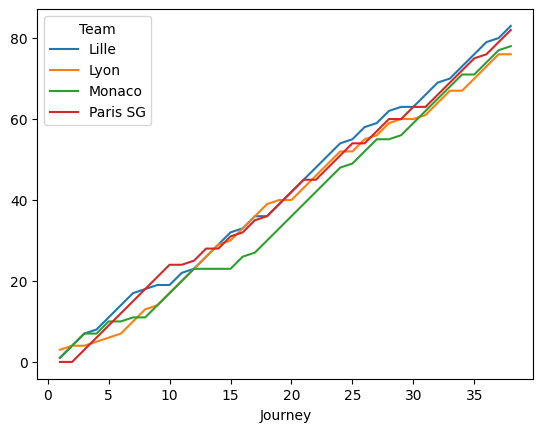

In [17]:
plot_cumpoints(2021, "Ligue 1", ["Lille", "Paris SG", "Lyon", "Monaco"])

# Creating functions to get positions of clubs

In [18]:
def plot_positions(season, league, clubs=None):
    season_league_results = get_season_league_journey_points(season, league)
    if clubs is None:
        clubs_to_plot = season_league_results.Team.unique()
    else:
        clubs_to_plot = clubs
    ax = (
        season_league_results.query('Team in @clubs_to_plot')
        .pivot_table(values='Position', columns='Team', index='Journey')
        .plot(figsize=(10,5))
    )
    ax.invert_yaxis()
    ax.set_yticks(list(range(1, 21)))
    ax.set_ylim((21,0))
    ax.set_xticks(list(range(1, 39)))
    ax.plot()

# Showing the positions of 3 teams during different season

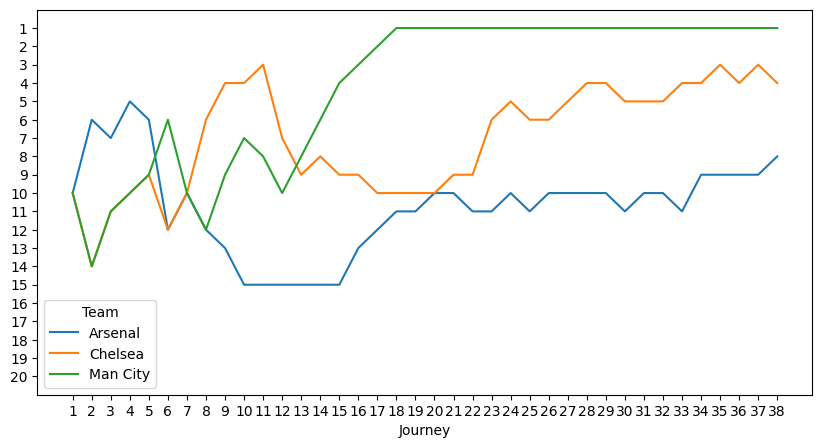

In [19]:
plot_positions(2021, "Premier League", ["Arsenal", "Man City", "Chelsea"])

In [20]:
all_seasons = df.season.unique()

# Creating a pivot table to show positions of different clubs among different seasons

In [21]:
def get_league_historic(league, formatting=True):
    all_seasons_league_list = []

    for season in tqdm(all_seasons):

        final_classement_season = (
            get_final_classment(season, league)
            .reset_index()
            .rename(columns={'index': 'club'})
            .assign(season=season)
            .assign(rank=lambda x: x['rank'].astype(int))
        )
        all_seasons_league_list.append(final_classement_season)

    all_seasons_league_df = pd.concat(all_seasons_league_list)

    all_seasons_league_ts = all_seasons_league_df.pivot_table(values='rank', index='club', columns='season')
    if formatting:
        all_seasons_league_ts = (
            all_seasons_league_ts
            .style
            .format(None, na_rep="L2", precision=0)
            .highlight_null()
            .background_gradient(cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
        )
    return all_seasons_league_ts


In [22]:
all_seasons_bundesliga = get_league_historic("LaLiga")
all_seasons_bundesliga

  0%|          | 0/16 [00:00<?, ?it/s]

season,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
club,,,,,,,,,,,,,,,,
Alaves,18,L2,L2,L2,L2,L2,L2,L2,L2,L2,L2,9,14,10,16,15
Almeria,L2,L2,8,11,13,20,L2,L2,16,19,L2,L2,L2,L2,L2,L2
Ath Bilbao,12,16,11,13,8,6,10,12,4,7,5,7,16,7,11,9
Ath Madrid,10,6,4,4,9,6,5,3,1,3,3,3,2,2,3,1
Barcelona,1,1,3,1,1,1,2,1,2,1,1,2,1,1,2,3
Betis,14,16,13,17,L2,L2,12,7,20,L2,10,14,6,10,15,6
Cadiz,19,L2,L2,L2,L2,L2,L2,L2,L2,L2,L2,L2,L2,L2,L2,11
Celta,6,18,L2,L2,L2,L2,L2,17,8,8,6,13,12,16,17,8
Cordoba,L2,L2,L2,L2,L2,L2,L2,L2,L2,20,L2,L2,L2,L2,L2,L2
